# CIVIL-557 Decision Aid Methodologies in Transportation
## July 2020 - Final coursework project
### This notebook was authored by
    - Léandre Tarpin-Pitre
    - Mathieu Bélanger

# 0 Librairies importation and management

In [1]:
import numpy  as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import  MinMaxScaler, OneHotEncoder
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from xgboost.sklearn import XGBClassifier
import xgboost as xgb

import time

from scipy.stats import randint as sp_randint, uniform as sp_uniform

import matplotlib.pyplot as plt

## 0.1 Data importation

In [2]:
data_train = pd.read_csv('../data/cmap-chicago-travel/train_validate.csv', index_col='trip_id')
data_predictions = pd.read_csv('../data/cmap-chicago-travel/test.csv', index_col='trip_id')

In [3]:
data_train.head()

,household_id,person_id,trip_number,choice,travel_dow,trip_purpose,distance,departure_hour,departure_min,hh_vehicles,hh_size,hh_bikes,hh_descr,hh_income,gender,age,license,education_level,work_status
trip_id,,,,,,,,,,,,,,,,,,,
1,1,1,1,drive,7,HOME_OTHER,23.42579,9.0,20.0,2,2,0,2,6,1,66,1.0,6,FTE
2,1,1,2,drive,7,OTHER,1.71259,12.0,5.0,2,2,0,2,6,1,66,1.0,6,FTE
3,1,1,3,drive,7,HOME_OTHER,21.77887,15.0,30.0,2,2,0,2,6,1,66,1.0,6,FTE
4,1,1,4,drive,7,SHOPPING,2.02603,17.0,30.0,2,2,0,2,6,1,66,1.0,6,FTE
5,1,1,5,drive,7,SHOPPING,0.87691,18.0,15.0,2,2,0,2,6,1,66,1.0,6,FTE


# 1 Data pre-processing

## 1.1 Categorical data encoding

In [4]:
### Same categories for train and test set (for the categorical columns)
set(data_train['trip_purpose'].value_counts()) == set(data_predictions['trip_purpose'].value_counts())
set(data_train['work_status'].value_counts()) == set(data_predictions['work_status'].value_counts())

### Assess the low cardinality of the categorical variables (for efficient one-hot encoding)
display(data_train['trip_purpose'].value_counts())
display(data_train['work_status'].value_counts())
display(data_train['hh_descr'].value_counts())

### Missing (nan) values in the dfs?
display(data_train.isnull().sum())
display(data_predictions.isnull().sum())

HOME_OTHER         18937
SHOPPING           13373
ESCORT_TRANSFER     9184
HOME_WORK           8060
OTHER               6680
HOME_EDU            3749
BUSINESS            1554
Name: trip_purpose, dtype: int64

FTE           26943
Student       11204
Retired        8039
PTE            6187
Volunteer      2900
Homemaker      2458
Unemployed     1927
Unknown        1879
Name: work_status, dtype: int64

1    43990
3    12315
2     5232
Name: hh_descr, dtype: int64

household_id       0
person_id          0
trip_number        0
choice             0
travel_dow         0
trip_purpose       0
distance           0
departure_hour     0
departure_min      0
hh_vehicles        0
hh_size            0
hh_bikes           0
hh_descr           0
hh_income          0
gender             0
age                0
license            0
education_level    0
work_status        0
dtype: int64

household_id       0
person_id          0
trip_number        0
travel_dow         0
trip_purpose       0
distance           0
departure_hour     0
departure_min      0
hh_vehicles        0
hh_size            0
hh_bikes           0
hh_descr           0
hh_income          0
gender             0
age                0
license            0
education_level    0
work_status        0
dtype: int64

In [5]:
data_train.dtypes

household_id         int64
person_id            int64
trip_number          int64
choice              object
travel_dow           int64
trip_purpose        object
distance           float64
departure_hour     float64
departure_min      float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status         object
dtype: object

In [6]:
# Columns chosen for categorical one-hot encoding
# One-hot encoding will be applied since we don't want a proportionnal relation 
# to be fitted between the classes of each column

categorical_cols = ['travel_dow','hh_descr','trip_purpose','work_status', 'license', 'gender']

In [7]:
def preprocessing(df):
  # To one-hot encode these numerical columns we have to convert the values to string
  df['travel_dow'] = df['travel_dow'].apply(str)
  df['gender'] = df['gender'].apply(str)
  df['license'] = df['license'].apply(str)
  df['hh_descr'] = df['hh_descr'].apply(str)
  
  # Concatenate time departure
  # Increased granularity for the time data. Departure minutes alone does not mean much.
  df['departure_time'] = df['departure_hour'] + df['departure_min']/60
  df = df.drop(['departure_hour', 'departure_min'], axis=1)

  return df

data_train = preprocessing(data_train)
data_predictions = preprocessing(data_predictions)




## 1.2 Train-test segmentation

In [8]:
target = ['choice']
id_context = [#'household_id', removed to permit grouped-cross-validation
              'person_id',
              'trip_number'
             ]
features = [column for column in data_train.columns 
            if column not in (target + id_context)]

y = data_train[target]
X = data_train[features]

X_data_predictions = data_predictions[features]
X_data_predictions = X_data_predictions.drop('household_id', axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

y_train = y_train.choice.values
y_test = y_test.choice.values

# 1.3 Feature engineering

Here I start to lay out the bases of the sklearn pipeline that will be used to automate and encapsulate the preprocessing, parameter tuning and even model choosing. 

Since this dataset did not require a lot of preprocessing, the pipeline is quite light. However pipelines can seem a bit daunting to learn and apply from data input to final predictions, it was a good moment to try to use them.


### 1.3.1 Scaling of numerical columns
A minmax scaler is used since it is more suited for generic scaling (minimal outliers and we don't want to lose the original distribution form)

In [10]:
to_scale_cols = ['distance', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'age', 'education_level', 'departure_time']

scaling_pipeline = Pipeline([
                             ('minMax', MinMaxScaler())
])

## 1.3.2 One-hot encoding the categorical variables


In [11]:
class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype('category').apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
        ))

# Chosen categorical columns are encoded to dummy variables
categorical_pipeline = Pipeline([
                         ('labeler', StringIndexer()),
                         ('encoder', OneHotEncoder(handle_unknown='ignore')),
                         ])

## 1.4 Feature Union

In [12]:
preprocessor = ColumnTransformer([
    ('categorical_cols', categorical_pipeline, categorical_cols),
    ('scaled_cols', scaling_pipeline, to_scale_cols)
])

# 2 Models definition 

## 2.1 Pipeline setup

In [13]:
class ClfSwitcher(ClassifierMixin, BaseEstimator):

    def __init__(
        self, 
        estimator = SGDClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

By lack of time & access to a sufficient computing machine (Google collab is often a bit unstable where I am), the model list is
reduced. But the proof of concept is there. This architecture can handle as many
different models as required combined with randomised search CV.

I reduced the list and search scope to be able to fully rerun the notebook once
before handing the project

In [14]:
# List of models to be tested, with the parameter distribution for the Randomized
#search

params = [
    {
        'clf__estimator': [RandomForestClassifier()],
        "clf__estimator__max_depth": sp_randint(2,15),
        "clf__estimator__max_features": sp_randint(2,15),
        "clf__estimator__min_samples_split": sp_randint(2, 5),
        "clf__estimator__min_samples_leaf": sp_randint(2, 5),
        "clf__estimator__n_estimators" : sp_randint(50,150)
    },
    {
        'clf__estimator': [XGBClassifier(#objective='multi:softmax', 
                                         #num_class = 4,
                                         scale_pos_weight=1,
                                         verbosity = 0,
                                         early_stopping_rounds = 5)],
        "clf__estimator__n_estimators" : sp_randint(100,300),
        'clf__estimator__max_depth': sp_randint(3,12),
        'clf__estimator__min_child_weight': sp_randint(1,7),
        'clf__estimator__gamma': [0, 0.05, 0.1, 0.2],
        'clf__estimator__subsamble': [i/100.0 for i in range(75,90,5)],
        'clf__estimator__colsample_bytree': [i/100.0 for i in range(75,90,5)],
        #'clf__estimator__learning_rate': [0.01, 0.0125, 0.015, 0.0175, 0.02],
    }
]

classifier_pipeline = Pipeline([
    ('features_preprocessed', preprocessor),
    ('clf', ClfSwitcher()),
])

# We group on household to prevent data-leakage during cross-validation
gkf = GroupKFold(n_splits= 5)


# Randomized search is operated on all models to find the best combination
# of model-parameters
rscv = RandomizedSearchCV(estimator = classifier_pipeline,
                          param_distributions=params[1],
                          scoring = "neg_log_loss",
                          n_jobs = -1,
                          cv = gkf,
                          n_iter = 60,
                          verbose=1)

search = rscv.fit(X_train,y_train,groups = X_train['household_id'])

search.best_params_
search.cv_results_['mean_fit_time'][search.best_index_]
search.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 94.0min
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 155.9min finished


-0.5958151549960242

In [15]:
# The best model is retrieved from the pipeline
best_model = search.best_estimator_['clf'].estimator

#3 Evaluation and testing

## 3.1 Confusion matrix of the sub-train predictions

In [16]:
# We refit on the whole train set
search.best_estimator_.fit(X_train, y_train)
preds = search.best_estimator_.predict(X_test)

Confusion matrix, without normalization:


array([[   8,   62,   12,   11,   30],
       [   0, 7044,   43,   37,  141],
       [   0,  893, 1561,  108,  133],
       [   0,  328,  146,  351,   41],
       [   3,  348,  138,   31,  839]])

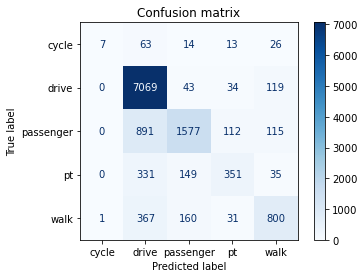

Accuracy: 79.65%
Log Loss = 0.5490


In [17]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

print('Confusion matrix, without normalization:')
display(confusion_matrix(y_test, preds))

fig, ax = plt.subplots()
plot_confusion_matrix(best_model, preprocessor.fit_transform(X_test), y_test,values_format= 'd', cmap=plt.cm.Blues, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

# Accuracy
acc = metrics.accuracy_score(preds, y_test)
print("Accuracy: {:.2f}%".format(acc*100))

# Cross entropy loss
logl = log_loss(y_test, search.best_estimator_.predict_proba(X_test))
print("Log Loss = {:.4f}".format(logl))

# 4 Final predictions

## 4.1 Refit and predictions over real test data



In [18]:
# refit on whole dataset
search.best_estimator_.fit(X, y)

# final predictions
y_pred_proba = search.best_estimator_.predict_proba(pd.DataFrame(X_data_predictions, columns=X_train.columns))
y_pred = search.best_estimator_.predict(pd.DataFrame(X_data_predictions, columns=X_train.columns))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## 4.2 Output for scoring on kaggle

In [19]:
predictions_output_df = pd.DataFrame(y_pred_proba, columns=best_model.classes_)
predictions_output_df.head()

# Concatenate back the predictions with the indexes from the input data
predictions_output_df.set_index(data_predictions.index).to_csv('predictions.csv')

# predictions_output_df